In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D,Conv2D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

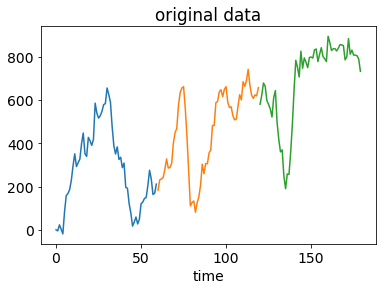

data:  10000


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

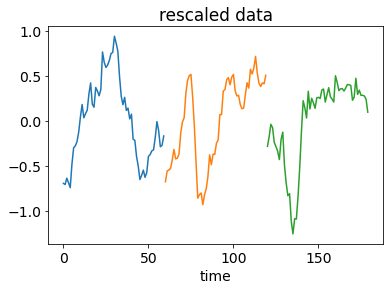

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [4]:
# ... LESSON ...
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345) # same thing with tensor module

from keras import regularizers, initializers

reg = regularizers.l2(0.02) # lambda value I guess, l2 is ridge, l1 would be lasso
ini = initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)

NCONV = 1
NF = 5

model = Sequential()

if NCONV==1:
    #---1----
    model.add(Conv1D(filters=NF,kernel_size=11,kernel_initializer=ini,kernel_regularizer=reg,activation='relu',input_shape=input_shape))
    #model.add(MaxPooling1D(3)) this would pool using the maximum
    model.add(AveragePooling1D(5)) # pooling using the average of the neurons (5 neurons)
    model.add(Conv1D(filters=5,kernel_size=7,activation='relu'))
    model.add(Flatten()) # flatten the 2d into a 1d
    model.add(Dense(12,activation='relu')) # just a 12 neurons layer
    model.add(Dropout(0.2)) # dropout layer with rate 0.2

if NCONV==2:
    #-----2---#
    model.add(Conv1D())

model.add(Dense(n_class,activation='softmax')) # OUTPUT LAYER! same for both models

print('---MODEL {} ------'.format(NCONV))
print(model.summary())

# optimizers
#.SGD
#.RMSprop
#.Nadam


opt = tf.keras.optimizers.Adam()

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

---MODEL 1 ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 5)             60        
                                                                 
 average_pooling1d (AverageP  (None, 10, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 5)              180       
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 12)                252       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                      

In [5]:
model.layers

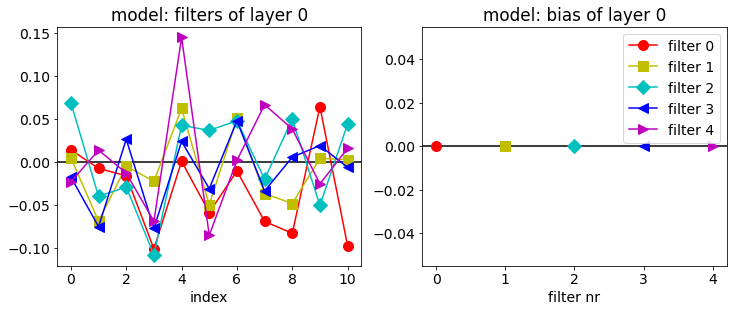

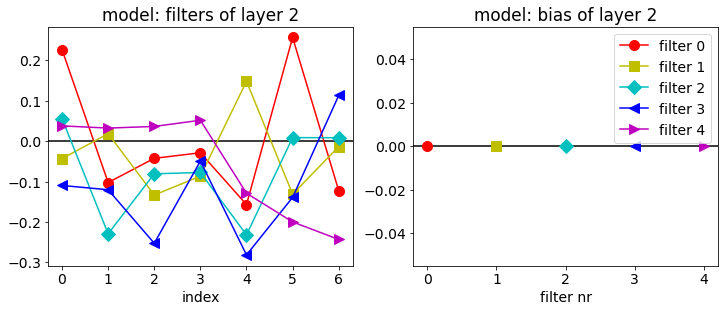

In [6]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0) # 11 numbers, i.e. the weights of the first convolutional kernel
Show_weights(model,2)

In [7]:
# ...LESSON ...
BATCH_SIZE = 250
EPOCHS = 100

print('------- Model {} ------- \n FITTING....'.format(NCONV))
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_val,y_val),verbose=2,shuffle=True)

------- Model 1 ------- 
 FITTING....
Epoch 1/100
32/32 - 0s - loss: 1.0994 - accuracy: 0.3483 - val_loss: 1.0951 - val_accuracy: 0.3835 - 450ms/epoch - 14ms/step
Epoch 2/100
32/32 - 0s - loss: 1.0874 - accuracy: 0.4009 - val_loss: 1.0735 - val_accuracy: 0.4205 - 74ms/epoch - 2ms/step
Epoch 3/100
32/32 - 0s - loss: 1.0498 - accuracy: 0.4794 - val_loss: 1.0219 - val_accuracy: 0.5345 - 73ms/epoch - 2ms/step
Epoch 4/100
32/32 - 0s - loss: 0.9823 - accuracy: 0.5732 - val_loss: 0.9340 - val_accuracy: 0.6545 - 74ms/epoch - 2ms/step
Epoch 5/100
32/32 - 0s - loss: 0.9011 - accuracy: 0.6338 - val_loss: 0.8323 - val_accuracy: 0.7085 - 74ms/epoch - 2ms/step
Epoch 6/100
32/32 - 0s - loss: 0.7973 - accuracy: 0.6981 - val_loss: 0.7261 - val_accuracy: 0.7655 - 72ms/epoch - 2ms/step
Epoch 7/100
32/32 - 0s - loss: 0.7026 - accuracy: 0.7454 - val_loss: 0.6202 - val_accuracy: 0.8075 - 73ms/epoch - 2ms/step
Epoch 8/100
32/32 - 0s - loss: 0.6106 - accuracy: 0.7795 - val_loss: 0.5253 - val_accuracy: 0.8455 

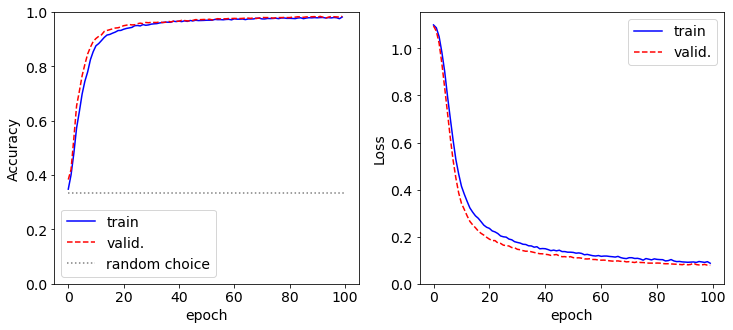

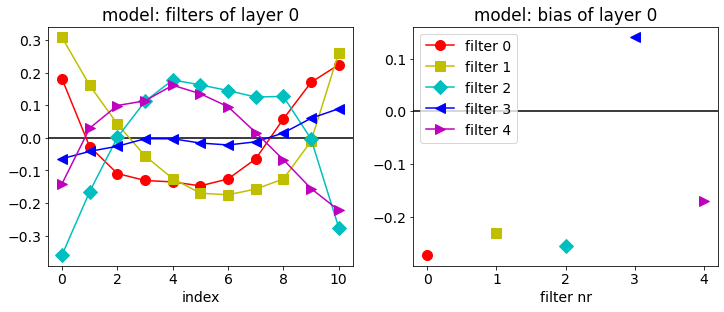

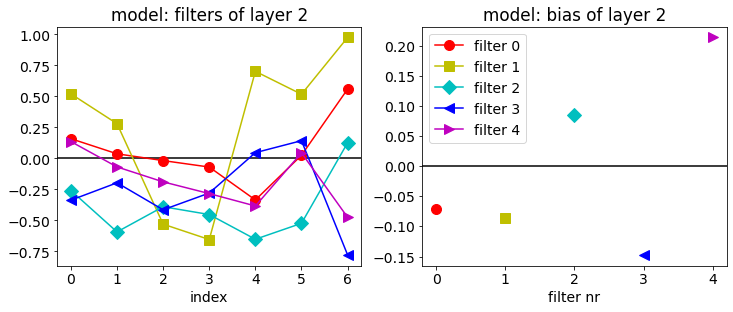

In [8]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

In [9]:
# ...LESSON ...

reg2 = regularizers.l2(2.0)
model2 = keras.models.clone_model(model)
# same model with stronger reg
model2.layers[0].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2=250
EPOCHS2 = 100

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,validation_data=(x_val,y_val),verbose=2,shuffle=True)

Epoch 1/100
32/32 - 0s - loss: 1.0324 - accuracy: 0.4457 - val_loss: 0.8910 - val_accuracy: 0.6490 - 445ms/epoch - 14ms/step
Epoch 2/100
32/32 - 0s - loss: 0.7770 - accuracy: 0.7074 - val_loss: 0.6098 - val_accuracy: 0.8195 - 133ms/epoch - 4ms/step
Epoch 3/100
32/32 - 0s - loss: 0.5398 - accuracy: 0.8170 - val_loss: 0.3965 - val_accuracy: 0.8815 - 115ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.4028 - accuracy: 0.8734 - val_loss: 0.3121 - val_accuracy: 0.9135 - 109ms/epoch - 3ms/step
Epoch 5/100
32/32 - 0s - loss: 0.3334 - accuracy: 0.9019 - val_loss: 0.2674 - val_accuracy: 0.9240 - 104ms/epoch - 3ms/step
Epoch 6/100
32/32 - 0s - loss: 0.2981 - accuracy: 0.9122 - val_loss: 0.2359 - val_accuracy: 0.9295 - 111ms/epoch - 3ms/step
Epoch 7/100
32/32 - 0s - loss: 0.2679 - accuracy: 0.9236 - val_loss: 0.2199 - val_accuracy: 0.9405 - 130ms/epoch - 4ms/step
Epoch 8/100
32/32 - 0s - loss: 0.2547 - accuracy: 0.9271 - val_loss: 0.2036 - val_accuracy: 0.9445 - 109ms/epoch - 3ms/step
Epoch 9

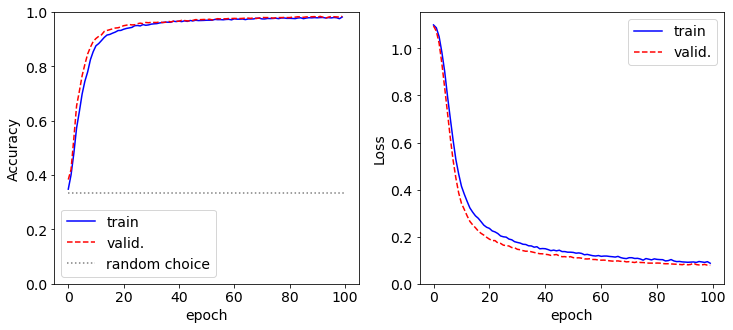

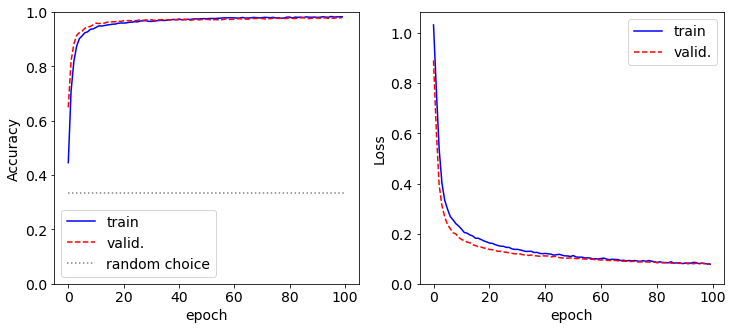

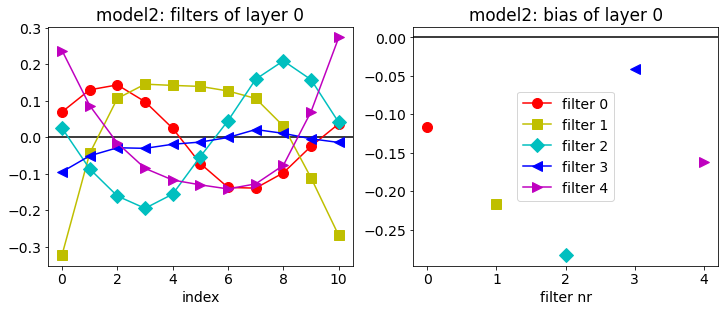

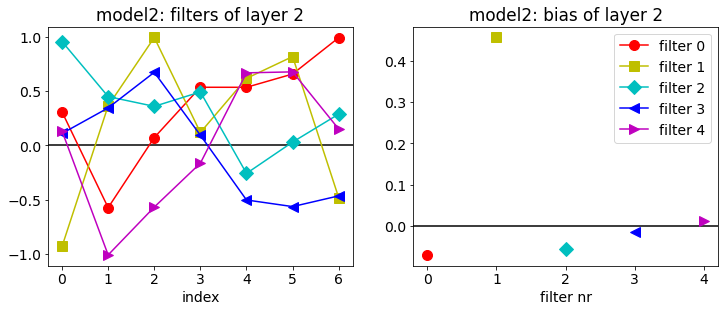

In [10]:
Show_history(fit)
Show_history(fit2)
Show_weights(model2,0,label="model2")
Show_weights(model2,2,label="model2")

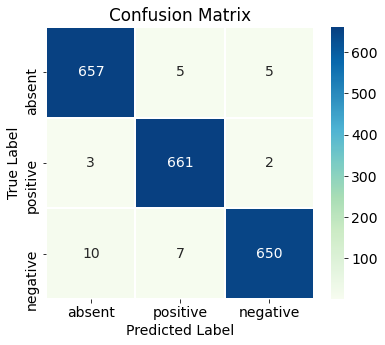

In [11]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)

#print(classification_report(max_y_val, max_y_pred_val))